# PostgreSQL: DVD Rental Database

- Discovering the DVD Rental Database using SQL & Python. 
- The DVD rental database represents the business processes of a DVD rental store
- We solve the following business tasks to create business implications:
1. TASK: Create an overdue DVD-rental column & calculacte the average and total of not returned DVD's.
2. TASK: Calculate the total replacement costs of not returned DVD's.
3. TASK: Discover the total sales & location (country, city) of each store.
4. TASK: Explore the customer segments of each store. What are the top 10 countries of residence of each stores unique customers. 
5. TASK: Visually compare results of TASK (4) for the different stores.
6. TASK: Discover the top genres by total rentals.
7. TASK: Discover the top 3 genres of India and China.


----------------------------------------------------------------------------------

In [1]:
# Import necessary libraries
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps

Connecting to the PostgreSQL-Server and the DVD Rental Database on my local computer

In [2]:
# Connecting to a PostgreSQL-Server using 'psycopg2' library
conn2 = ps.connect(dbname = "dvdrental",
                   user = "postgres",
                   password = "password",
                   host = "localhost",
                   port = "5432")

Exploring Data Base Informations

In [3]:
# A: Discover table informations from the system database 'INFORMATION_SCHEMA' 
# 1. Select name, type, schema, and catalog of all tables with 'sql1' query
sql1 = """

SELECT table_name, table_type, table_catalog
FROM INFORMATION_SCHEMA.TABLES
WHERE table_schema = 'public';

"""

In [4]:
# 2. Store and View results in 'pandas' DataFrame 
df_table_info = sqlio.read_sql_query(sql1, conn2)
df_table_info

,table_name,table_type,table_catalog
0,actor,BASE TABLE,dvdrental
1,actor_info,VIEW,dvdrental
2,customer_list,VIEW,dvdrental
3,film_list,VIEW,dvdrental
4,nicer_but_slower_film_list,VIEW,dvdrental
5,sales_by_film_category,VIEW,dvdrental
6,store,BASE TABLE,dvdrental
7,sales_by_store,VIEW,dvdrental
8,staff_list,VIEW,dvdrental
9,address,BASE TABLE,dvdrental


In [5]:
# B: Discover column informations of the rental table
# 1. Select column_name, data_type of customer table with 'sql2' query
sql2 = """

SELECT column_name, data_type
FROM INFORMATION_SCHEMA.COLUMNS 
WHERE table_name = 'rental';

"""

In [6]:
# 2. Store and View results in 'pandas' DataFrame 
df_rental_info = sqlio.read_sql_query(sql2, conn2)
df_rental_info

,column_name,data_type
0,rental_id,integer
1,rental_date,timestamp without time zone
2,inventory_id,integer
3,customer_id,smallint
4,return_date,timestamp without time zone
5,staff_id,smallint
6,last_update,timestamp without time zone


-------

### Task1: Create a overdue DVD-rental column & calculacte the average and total of not returned DVD's

- 'rental_duration', 'title'  for DVD is given in 'film' table. 
- 'inventory_id', 'return_date', 'rental_date' is given in 'rental' table.
- we classify 'overdue' rentals as 1, if 'rental_date' + 'rental_duration' is smaller than 'return_date', or if 'return_date' is null (still pending).

In [7]:
sql_3 ="""
/* creating CTE to initiate a CASE on expected_return_date in the next Statement*/
WITH cte_expect AS(
  SELECT f.title,
         r.rental_date,
         f.rental_duration,
         r.inventory_id,
         INTERVAL '1' day * f.rental_duration + r.rental_date AS expected_return_date,
         r.return_date
  FROM film AS f
  INNER JOIN inventory AS i ON f.film_id = i.film_id
  INNER JOIN rental AS r ON i.inventory_id = r.inventory_id
  ORDER BY f.title)

SELECT inventory_id,
       title,
       rental_date,
       rental_duration,
       return_date,
       expected_return_date,
       (CASE 
            WHEN expected_return_date < return_date THEN 1
            WHEN expected_return_date > return_date THEN 0
            WHEN return_date IS NULL THEN 1
        END) AS overdue   
       
FROM cte_expect;

"""

In [8]:
df_3 = sqlio.read_sql_query(sql_3, conn2)
df_3.head(10)

,inventory_id,title,rental_date,rental_duration,return_date,expected_return_date,overdue
0,3,Academy Dinosaur,2005-07-31 21:36:07,6,2005-08-03 23:59:07,2005-08-06 21:36:07,0.0
1,8,Academy Dinosaur,2005-07-31 22:08:29,6,2005-08-06 16:59:29,2005-08-06 22:08:29,0.0
2,6,Academy Dinosaur,2005-07-27 07:51:11,6,2005-08-01 04:08:11,2005-08-02 07:51:11,0.0
3,8,Academy Dinosaur,2005-08-18 18:36:16,6,2005-08-22 22:01:16,2005-08-24 18:36:16,0.0
4,4,Academy Dinosaur,2005-08-02 00:47:19,6,2005-08-03 00:02:19,2005-08-08 00:47:19,0.0
5,1,Academy Dinosaur,2005-07-08 19:03:15,6,2005-07-11 21:29:15,2005-07-14 19:03:15,0.0
6,3,Academy Dinosaur,2005-08-22 23:56:37,6,2005-08-25 18:58:37,2005-08-28 23:56:37,0.0
7,2,Academy Dinosaur,2005-05-30 20:21:07,6,2005-06-06 00:36:07,2005-06-05 20:21:07,1.0
8,6,Academy Dinosaur,2005-06-21 00:30:26,6,2005-06-28 03:42:26,2005-06-27 00:30:26,1.0
9,6,Academy Dinosaur,2005-08-21 00:30:32,6,NaT,2005-08-27 00:30:32,1.0


In [9]:
sql_4 ="""

/*Spliting sql_3 into two CTE's to access overdue column in the SELECT statement*/

WITH cte_expect AS(
  SELECT f.title,
         r.rental_date,
         f.rental_duration,
         r.inventory_id,
         INTERVAL '1' day * f.rental_duration + r.rental_date AS expected_return_date,
         r.return_date
  FROM film AS f
  INNER JOIN inventory AS i ON f.film_id = i.film_id
  INNER JOIN rental AS r ON i.inventory_id = r.inventory_id
  ORDER BY f.title),
  
cte_overdue AS(
  SELECT inventory_id,
         title,
         rental_date,
         rental_duration,
         return_date,
         expected_return_date,
         (CASE 
              WHEN expected_return_date < return_date THEN 1
              WHEN expected_return_date > return_date THEN 0
              WHEN return_date IS NULL THEN 1
          END) AS overdue   
       
  FROM cte_expect)

  
SELECT AVG(overdue) AS overdue_avg,
       SUM(overdue) AS overdue_total
    
FROM cte_overdue;

"""

In [10]:
df_4 = sqlio.read_sql_query(sql_4, conn2)
df_4

,overdue_avg,overdue_total
0,0.517641,8304


1. ANSWER: From a total of 16044 DVD rentals, 8304 have been returned overdue. 51.18% percent of DVD's have been returned overdue.

**Business Implication**: The DVD rental company could potentially increase the overdue-return fees to increaes profit.

-----

### Task2: Calculate the total replacment costs of not returned DVD's

In [11]:
# We need to consider all rentals that have no return_date but a rental_date
# film, rental, and inventory need to be joined

sql_5 ="""

SELECT SUM(f.replacement_cost) as total_replacement_costs,
       COUNT(*) AS total_not_returned
       
FROM film AS f
  FULL OUTER JOIN inventory AS i ON f.film_id = i.film_id
  FULL OUTER JOIN rental AS r ON i.inventory_id = r.inventory_id

WHERE return_date is NULL
  AND rental_date is NOT NULL;
  
"""

In [12]:
df_5 = sqlio.read_sql_query(sql_5, conn2)
df_5

,total_replacement_costs,total_not_returned
0,3552.17,183


2. ANSWER: The total replacement costs for the total of 183 not returned DVD's are 3.552,17$.

**Business Implication**: The risk off replacement costs needs to be considered in the price calculation.

------------

### TASK3: Discover the total sales & location (country, city) of each store

In [13]:
sql_6 ="""

/*'cte_loc creates' locational data for each store */
WITH cte_loc AS (
  SELECT store_id, country, city, district

  FROM store
    LEFT JOIN address USING (address_id)
    LEFT JOIN city AS ci USING (city_id)
    LEFT JOIN country AS co USING (country_id)
    ),
    

/*'cte_total_sales' creates total sales data for each store */
cte_total_sales AS(
  SELECT SUM(p.amount) AS total_sales,
         store_id

       
  FROM payment AS p
    LEFT JOIN customer AS cu USING (customer_id)
    LEFT JOIN address AS a USING (address_id)
    LEFT JOIN city AS ci USING (city_id)
    LEFT JOIN country AS co USING (country_id)
  
  GROUP BY (cu.store_id)
  )
  
  
  
SELECT store_id,
       country,
       district,
       city,
       total_sales

FROM cte_loc
  LEFT JOIN cte_total_sales USING (store_id);

  

"""

In [14]:
df_6 = sqlio.read_sql_query(sql_6, conn2)
df_6

,store_id,country,district,city,total_sales
0,1,Canada,Alberta,Lethbridge,33621.42
1,2,Australia,QLD,Woodridge,27690.62


3. ANSWER: The DVD-rental company has two stores. One in Canada, Lethbridge (Alberta) with total sales of 33621.42 USD. 
And a second store in Australia, Woodridge (QLD) with total sales of 27690.62 USD.

**Business Implication**: The Store in Canada has generated the most sales revenue. Deeper analyze the difference between the two stores to understand the variables leading to higher revenue in Canada.

-------

### TASK4: Explore the customer segment of each store. What are the top 10 countries of residence of each stores unique customers.

In [15]:
sql_7 ="""

WITH cte_top_country_customer AS(
  SELECT country,
         COUNT(country) AS country_customer_total,
         RANK()
           OVER (ORDER BY COUNT(country) DESC) AS rank_country,
         (SELECT COUNT(*) FROM customer WHERE store_id = 1) as total_unique_customer_store
       
  FROM customer
    LEFT JOIN address USING (address_id)
    LEFT JOIN city USING (city_id)
    LEFT JOIN country USING (country_id)

  /*Select Store in Canada*/
  WHERE store_id = 1
  GROUP BY country
  ORDER BY COUNT(country) DESC
)

SELECT *,
       (country_customer_total* 1.0 / total_unique_customer_store) AS perc_of_total_customer 
       
FROM cte_top_country_customer;
    
"""

In [16]:
df_7 = sqlio.read_sql_query(sql_7, conn2)
df_7.head(10)

,country,country_customer_total,rank_country,total_unique_customer_store,perc_of_total_customer
0,India,37,1,326,0.113497
1,China,26,2,326,0.079755
2,United States,22,3,326,0.067485
3,Japan,17,4,326,0.052147
4,Russian Federation,16,5,326,0.049080
5,Mexico,15,6,326,0.046012
6,Brazil,15,6,326,0.046012
7,Philippines,13,8,326,0.039877
8,Turkey,9,9,326,0.027607
9,South Africa,9,9,326,0.027607


In [17]:
sql_8 ="""

WITH cte_top_country_customer AS(
  SELECT country,
         COUNT(country) AS country_customer_total,
         RANK()
           OVER (ORDER BY COUNT(country) DESC) AS rank_country,
         (SELECT COUNT(*) FROM customer WHERE store_id = 2) as total_unique_customer_store
       

       
  FROM customer
    LEFT JOIN address USING (address_id)
    LEFT JOIN city USING (city_id)
    LEFT JOIN country USING (country_id)

  /*Select Store in Australia*/
  WHERE store_id = 2
  GROUP BY country
  ORDER BY COUNT(country) DESC
)


SELECT *,
       (country_customer_total* 1.0 / total_unique_customer_store) AS perc_of_total_customer 
       
FROM cte_top_country_customer;

"""

In [18]:
df_8 = sqlio.read_sql_query(sql_8, conn2)
df_8.head(10)

,country,country_customer_total,rank_country,total_unique_customer_store,perc_of_total_customer
0,China,27,1,273,0.098901
1,India,23,2,273,0.084249
2,Mexico,15,3,273,0.054945
3,United States,14,4,273,0.051282
4,Japan,14,4,273,0.051282
5,Brazil,13,6,273,0.047619
6,Russian Federation,12,7,273,0.043956
7,Nigeria,7,8,273,0.025641
8,Indonesia,7,8,273,0.025641
9,Philippines,7,8,273,0.025641


4. ANSWER: The Top 10 countries of residence of unique customers partly overlaps in both stores. Most customers in both stores are from China or India.

**Business Implication**: Training the staff to understand the cultural needs of customers from China and India could improve customer satisfaction and could lead to an increae in revenue.

-----

### TASK5: Visually compare results of TASK (4) for the different stores

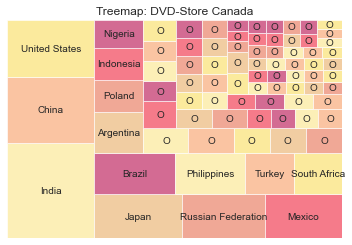

In [25]:
# Import necessary libraries for datavis
import squarify
import seaborn as sns
import matplotlib.pyplot as plt

# mark all countries with a customer total smaller or equal to 5 as 'O' (Others)
df_7.loc[df_7['country_customer_total'] <= 5, 'country'] = 'O'

colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c'] #color palette

sns.set_style(style="whitegrid") # set seaborn plot style
sizes= df_7["perc_of_total_customer"] # proportions of the categories
label=df_7["country"]
squarify.plot(sizes=sizes, label=label, alpha=0.6, color=colors).set(title='Treemap: DVD-Store Canada')
plt.axis('off')
plt.show()

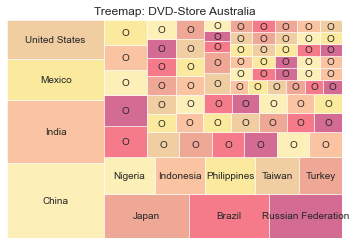

In [26]:
# mark all countries with a customer total smaller or equal to 5 as 'O' (Others)
df_8.loc[df_8['country_customer_total'] <= 5, 'country'] = 'O'

colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c'] #color palette

sns.set_style(style="whitegrid") # set seaborn plot style
sizes= df_8["perc_of_total_customer"] # proportions of the categories
label=df_8["country"]
squarify.plot(sizes=sizes, label=label, alpha=0.6, color=colors).set(title='Treemap: DVD-Store Australia')
plt.axis('off')
plt.show()

5. ANSWER: The customers in both stores come from a diverse international background. About 50% of Customers are coming from countries with 5 customers or less. 

**Business Implication**: The Corporate identity of the company should engage with the internationality of the companies customers. The staff should be trained in intercultural communication to improve customer satisfaction.

---------------------------------

### 6. TASK: Discover the top genres by total rentals.

In [21]:
sql_9 ="""

SELECT COUNT(r.rental_id) AS total_rentals,
       c.name

FROM rental AS r
  LEFT JOIN inventory AS i USING (inventory_id)
  LEFT JOIN film AS f USING (film_id)
  LEFT JOIN film_category AS fc USING (film_id)
  LEFT JOIN category AS c USING (category_id)
  
GROUP BY c.name
ORDER BY total_rentals DESC
  

"""

In [22]:
df_9 = sqlio.read_sql_query(sql_9, conn2)
df_9

,total_rentals,name
0,1179,Sports
1,1166,Animation
2,1112,Action
3,1101,Sci-Fi
4,1096,Family
5,1060,Drama
6,1050,Documentary
7,1033,Foreign
8,969,Games
9,945,Children


6. ANSWER: The most rented genre is Sports, followed by Animation and Action. The least rented genres are Music and Travel. The difference between most rented Sports (1179) and Music (830) is 349 rentals.

**Business Implication**: All genres are important revenue drivers for the company.

-----

### 7. TASK: Discover the top 3 genres of India and China.

In [23]:
sql_10 ="""

WITH cte_top_genre_india_china AS(
  SELECT COUNT(r.rental_id) AS total_rentals,
         c.name,
         co.country,
         RANK()
             OVER (PARTITION BY(country) ORDER BY COUNT(country) DESC) AS rank_country_genre

  FROM rental AS r
    LEFT JOIN inventory AS i USING (inventory_id)
    LEFT JOIN film AS f USING (film_id)
    LEFT JOIN film_category AS fc USING (film_id)
    LEFT JOIN category AS c USING (category_id)
    LEFT JOIN customer AS cu USING (customer_id)
    LEFT JOIN address AS a USING (address_id)
    LEFT JOIN city AS ci USING (city_id)
    LEFT JOIN country AS co USING (country_id)
  
  WHERE co.country = 'India' OR co.country = 'China'

  GROUP BY (co.country, c.name)
  ORDER BY country, total_rentals DESC
)

SELECT *
FROM cte_top_genre_india_china
WHERE rank_country_genre <= 3

"""

In [24]:
df_10 = sqlio.read_sql_query(sql_10, conn2)
df_10

,total_rentals,name,country,rank_country_genre
0,113,Animation,China,1
1,105,Family,China,2
2,105,Drama,China,2
3,118,Action,India,1
4,115,Sports,India,2
5,114,Documentary,India,3


7. ANSWER: The top genres of chinese customers are Animation are Animation, Familiy and Drama. The top genres of indian customers are Action, Sports and Documentary.

**Business Implication**: Advertisment of new and best rated DVD's of the top 3 genres is a efficient way to drive revenue, as they are the most rented genres of the most common nationalities.

----

# Thanks for making it to the end!
# there are more projects in the portfolio. 
# Hope to see u there :)